# **Recurrence plots and CNNs for time-series classification**
In this kernel we investigate how to use recurrence plots as pre-processing step for time-series, so we can classifiy them with convolutional neural nets. Since CNNs require images as inputs to be useful, one has to convert a time-series to an image. A typical approach is to convert the time-series to a spectrogram. This is disadvantageous since in a spectrogram it matters where an effect appears in contrast to CNNs where it is assumed that a feature is of the same kind, no matter where in the picture it is.
The usage of recurrence plots as visualization of the recurrence structure of a time-series is hence advantageous. 
In this kernel we will investigate the notion of recurrence plots and how to use it for time-series classification. 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
import time
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import np_utils


## Recurrence Plots
Recurrence plots are a visualization tool for (multivariate) time-series. They are based on exploring the characteristic recurrent behaviour of a time-series. Let $q(t) \in \mathbb{R}^d$ be a multi-variate time-series. It's recurrence plot is defined as
$$ RP_{i,j} = \theta( \epsilon - || q(i) - q(j) ||)$$
where $\epsilon$ is a threshold and $\theta$ is the heaviside function.  

In [5]:
#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

As a first example, we create the recurrence plot of a random time-series and a sinus series. Clearly the regular structure of the sinus is visible.

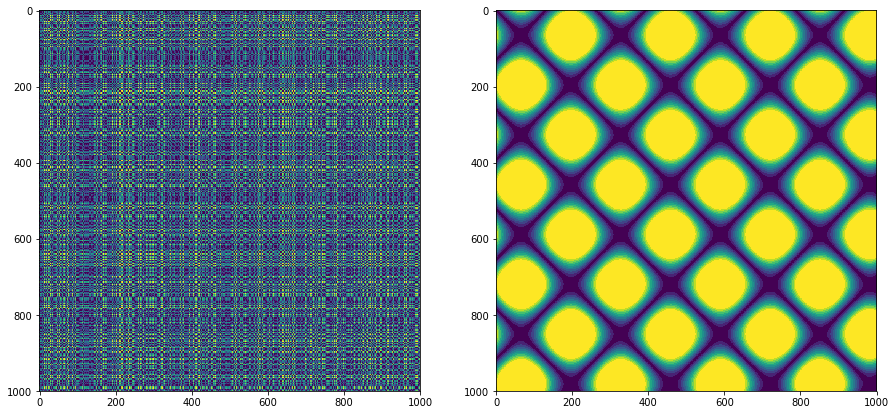

In [6]:
fig = plt.figure(figsize=(15,14))
random_series = np.random.random(1000)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(recurrence_plot(random_series[:,None]))
sinus_series = np.sin(np.linspace(0,24,1000))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(sinus_series[:,None]));

We investigate examples of the MotionSense data set.  We take for each of the activities - downstairs, upstairs, walking, jogging, sitting, and standing - a time-series of the first participant. 

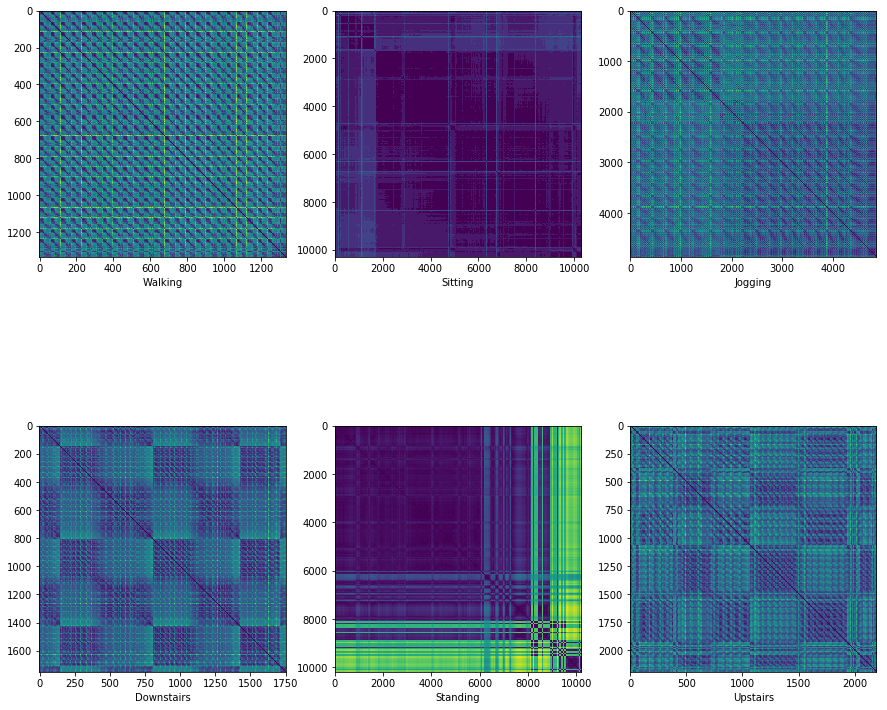

In [8]:
cols = ["attitude.roll","attitude.pitch","attitude.yaw","gravity.x","gravity.y","gravity.z","rotationRate.x","rotationRate.y","rotationRate.z","userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
data_dir = "./input/A_DeviceMotion_data/"
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(recurrence_plot(pd.read_csv(data_dir + "wlk_15/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Walking')
ax = fig.add_subplot(2, 3, 2)
ax.imshow(recurrence_plot(pd.read_csv(data_dir + "sit_5/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Sitting')
ax = fig.add_subplot(2, 3, 3)
ax.imshow(recurrence_plot(pd.read_csv(data_dir + "jog_9/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Jogging')
ax = fig.add_subplot(2, 3, 4)
ax.imshow(recurrence_plot(pd.read_csv(data_dir + "dws_1/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Downstairs')
ax = fig.add_subplot(2, 3, 5)
ax.imshow(recurrence_plot(pd.read_csv(data_dir + "std_6/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Standing')
ax = fig.add_subplot(2, 3, 6)
ax.imshow(recurrence_plot(pd.read_csv(data_dir + "ups_3/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Upstairs');

The images look rather different for very different activities, while walking/jogging, upstairs/downstairs, and sitting/standing are similiar to each other. Hence we can expect that image classification tools allow to distinguish between the recurrence plots of different activities. Since walking/jogging, upstairs/downstairs, and sitting/standing differ not that much, it is expected that these will not be so easy distinguishable.  For learning purposes we summarize these activities into one class each.
As a next step, we have to pre-process all the data, i.e. convert all the time-series to recurrence-plots and scale them to equal sizes. 



In [13]:
list(class_translate.keys())

['dws_1',
 'dws_2',
 'dws_11',
 'ups_3',
 'ups_4',
 'ups_12',
 'wlk_7',
 'wlk_8',
 'wlk_15',
 'jog_9',
 'jog_16',
 'std_6',
 'std_14',
 'sit_5',
 'sit_13']

In [ ]:
# convert folders to class labels
# downstairs/upstairs = 0,walking/jogging  = 1, standing/sitting = 2
class_translate = {"dws_1" : 0, "dws_2" : 0, "dws_11" : 0,  \
                   "ups_3" : 0, "ups_4" : 0, "ups_12" : 0, \
                   "wlk_7" : 1, "wlk_8" : 1, "wlk_15" : 1, \
                   "jog_9" : 1, "jog_16" : 1, \
                   "std_6" : 2, "std_14" : 2, \
                   "sit_5" : 2, "sit_13": 2}

pre allocate arrays
x_train = np.zeros((384,32,32))
y_train = np.zeros(384)
c = 0
start = time.time()
for i in class_translate.keys():    
    print("Processing set " + i)
    for j in range(1,25):
        dat = recurrence_plot(pd.read_csv(data_dir + i +"/" + "sub_"+ str(j) + ".csv")[cols].values, steps=100)
        dat = resize(dat, (32,32),mode='constant')
        x_train[c,:,:] = dat
        y_train[c] = class_translate[i]
        c = c + 1
end = time.time()
print('Elapsed time:')
print(end - start)

Processing set wlk_7
Processing set wlk_8
Processing set wlk_15
Processing set jog_9
Processing set jog_16
Processing set std_6


## CNNs for Recurrence plots
In https://arxiv.org/pdf/1710.00886.pdf the usage of a convolutional net for classification of recurrence plots is proposed. 

In [55]:
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

We normalize the data and save 10% for later evaluation of our model. 

In [16]:
#reshape to include depth
X_train = x_train.reshape(x_train.shape[0], 1, 32,32)
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
# convert labels to class matrix, one-hot-encoding
Y_train = np_utils.to_categorical(y_train, 3)
# split in train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [56]:
model.fit(X_train, Y_train, epochs=200, batch_size=16,shuffle=True)


Let's make predictions on the test set and compare with the real values.  We get good results for a very simple model.

In [59]:
predictions= model.predict(x_test)
rounded = [np.argmax(x) for x in predictions]
print(K.eval(metrics.categorical_accuracy(y_test, np_utils.to_categorical(rounded, 3))))
